# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [4]:
from choices import param_dict 
from utilities import deets

# Load data

In [161]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',])


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
y = df['class']

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


# Classification

### Using Sklearn API

In [141]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

In [143]:
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.1)
    cl_weight[cl] = w
cl_weight

{'STAR': 1.3179470606104418,
 'AGN': 1.3793432990559484,
 'YSO': 1.9552370229762268,
 'HMXB': 2.8022839541992157,
 'ULX': 38.32697077567007,
 'CV': 102.83057251027365,
 'LMXB': 222.57478508947435,
 'PULSAR': 2013.0523019776572}

In [144]:

train_data = lgb.Dataset(x_train , label=y_train)
test_data = lgb.Dataset(x_test , label=y_test , reference=train_data )
clf = lgb.LGBMClassifier(n_estimators=10 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity=0 , validation_fraction=0.2 ,random_state=42 , num_class = 2)
clf.fit(x_train , y_train ,)
#clf.score(x_test , y_test)

[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(class_weight={'AGN': 1.3793432990559484,
                             'CV': 102.83057251027365,
                             'HMXB': 2.8022839541992157,
                             'LMXB': 222.57478508947435,
                             'PULSAR': 2013.0523019776572,
                             'STAR': 1.3179470606104418,
                             'ULX': 38.32697077567007,
                             'YSO': 1.9552370229762268},
               is_unbalance=True, metric=['auc_mu'], n_estimators=10,
               num_class=2, objective='multiclass', random_state=42,
               sparse=True, validation_fraction=0.2, verbosity=0)

In [138]:
x_test.iloc[0:2]

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J085127.1+114656,6.779139,5.992593,NaN,NaN,8.557175,NaN,5.346122,2.0,5.837944e-09,0.004500,...,8.694702,2.252605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J193938.5+213459,4.979576,1.597467,NaN,NaN,0.501841,NaN,3.609130,0.0,1.178044e-09,0.127363,...,7.461071,5.982164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
clf.predict(x_test)

ValueError: y contains previously unseen labels: [ 9 63]

In [108]:
pre

[array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),


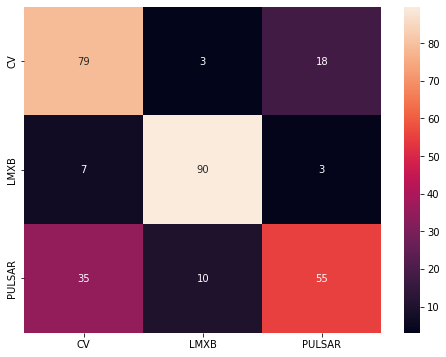

In [127]:
from sklearn.metrics import confusion_matrix
label = np.unique(y_test)
bst_clf = clf.best_iteration_
cm = confusion_matrix(y_test , clf.predict(x_test) , labels = label , normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm*100 , fmt='.0f' , annot=True , xticklabels=label, yticklabels=label)
plt.show()

## Cross validation

In [232]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.1)
    cl_weight[cl] = w
cl_weight


{'STAR': 1.3179470606104418,
 'AGN': 1.3793432990559484,
 'YSO': 1.9552370229762268,
 'HMXB': 2.8022839541992157,
 'ULX': 38.32697077567007,
 'CV': 102.83057251027365,
 'LMXB': 222.57478508947435,
 'PULSAR': 2013.0523019776572}

In [243]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res = simple_cv(x,y ,model=clf , k=20)

----------------------------------------------------------
GOING for 1 / 20 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


KeyboardInterrupt: 

In [209]:
res

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2592
 AGN           2224
 YSO           1060
 HMXB           688
 PULSAR         479
 ULX            251
 CV             214
 LMXB           195,
 'balanced_accuracy': 0.7285742789943046,
 'accuracy': 0.8451252758665455,
 'precision': 0.8936468478374868,
 'recall': 0.8451252758665455,
 'f1': 0.866034759941865,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.892276         0.960881  0.925309
 CV          0.560241         0.434579  0.489474
 HMXB        0.787433         0.856105  0.820334
 LMXB        0.804196         0.589744  0.680473
 PULSAR      0.465347         0.098121  0.162069
 STAR        0.873477         0.940201  0.905611
 ULX         0.606635         0.509960  0.554113
 YSO         0.838990         0.909434  0.872793,
 'res_table':      true_class pr

In [210]:
res['class_scores']

,recall_score,precision_score,f1_score
class,,,
AGN,0.892276,0.960881,0.925309
CV,0.560241,0.434579,0.489474
HMXB,0.787433,0.856105,0.820334
LMXB,0.804196,0.589744,0.680473
PULSAR,0.465347,0.098121,0.162069
STAR,0.873477,0.940201,0.905611
ULX,0.606635,0.509960,0.554113
YSO,0.838990,0.909434,0.872793


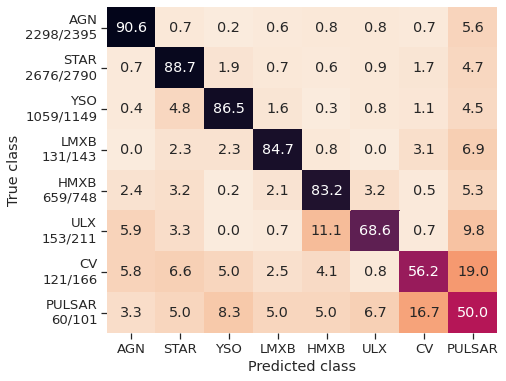

In [231]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 , 
    'cbar' : False ,
    'plot_num' : True,
}
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0.9)

### Prediction on New sources

In [221]:
pred_prob = clf.predict_proba(u)
u_df = pd.DataFrame({
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in clf.predict_proba(u)]
})


In [229]:
u_df_th = u_df[u_df['prob']>0.9]
u_df_th['class'].value_counts()

STAR      8201
AGN       7273
YSO       6037
HMXB      2761
ULX       1061
CV         645
PULSAR     601
LMXB       171
Name: class, dtype: int64

In [224]:
pred_prob_df = pd.DataFrame(pred_prob , columns=[f"prob_{el}" for el in res['clf'].classes_])
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
0,3.027403e-06,0.000010,0.999444,8.073311e-09,8.612147e-06,0.000532,3.011049e-06,2.396553e-09
1,8.124850e-05,0.000042,0.999792,2.939972e-08,5.897243e-07,0.000084,8.016801e-07,5.275538e-09
2,5.277775e-06,0.000010,0.997666,2.934285e-08,6.309252e-06,0.002281,3.166475e-05,7.910700e-09
3,3.136047e-05,0.000043,0.999469,1.232109e-07,6.637998e-06,0.000443,7.149677e-06,1.830680e-08
4,3.725444e-07,0.000005,0.998605,1.548311e-08,4.274649e-06,0.001385,2.307989e-08,2.864577e-09
...,...,...,...,...,...,...,...,...
39888,3.920427e-01,0.077794,0.516442,7.177123e-06,2.033693e-04,0.001169,1.233861e-02,3.502860e-06
39889,2.841406e-02,0.102506,0.867101,4.433187e-05,4.542904e-04,0.000329,1.149664e-03,1.761739e-06
39890,2.290546e-01,0.037660,0.726717,2.100940e-04,3.705640e-04,0.003362,2.608907e-03,1.628525e-05
39891,5.837411e-02,0.042572,0.353481,1.895362e-03,4.930424e-04,0.000353,5.428031e-01,2.777126e-05


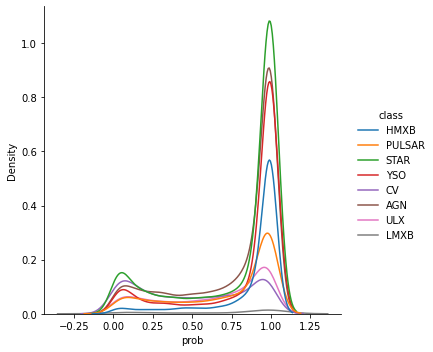

In [198]:
sns.displot(
    data = u_df ,
    kind='kde' ,
    x = 'prob' ,
    hue = 'class'
)
plt.show()